# Convolutional Neural Network for Sarcasm Detection


### Objective:
Using the dataset [News Headlines Dataset For Sarcasm Detection](https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection) created by [Rishabh Misra and Prahal Arora](https://arxiv.org/abs/1908.07414), the goal of this notebook is to illustrate the implementation of CNN for sarcasm detection.


## Data

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

root='/content/drive/My Drive/Colab Notebooks/data/'
train = pd.read_csv(root+"sarcasm/train.csv")
val = pd.read_csv(root+"sarcasm/val.csv")
test = pd.read_csv(root+"sarcasm/test.csv")

train.head()

,Unnamed: 0,headline,is_sarcastic
0,23789,the great vanishing,0
1,15323,mccain gets hammered at local vfw,1
2,18908,pissed off from a lack of sleep? you might be ...,0
3,21878,sitting inside cardboard box the safest 6-year...,1
4,15129,marcellus williams prosecutor drew scrutiny in...,0


In [ ]:
print(len(train),len(val),len(test))

19952 2850 5701


Let us to study the dataset. We can see that the dataset is balanced, that is, both classes (is_sarcastic) have similar number of instances.

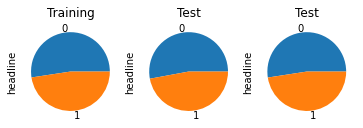

In [ ]:
import matplotlib.pyplot as plt

df1=train.groupby('is_sarcastic')['headline'].nunique()
df2=val.groupby('is_sarcastic')['headline'].nunique()
df3=test.groupby('is_sarcastic')['headline'].nunique()

# make a list of all dataframes 
nrow=1
ncol=3

df_list = [df1 ,df2, df3]
fig, axes = plt.subplots(1, 3)

# plot counter
count=0
for c in range(3):
    if c==0:
        strTitle='Training'
    elif c=='1':
        strTitle='Validation'
    else:
        strTitle='Test'

    df_list[count].plot(ax=axes[c], kind='pie', title=strTitle)
    count+=1

plt.show()



Moreover, we will study some characteristics of the headline (maximum length, average lenght, etc)


In [ ]:
train['length']=train['headline'].apply(len)
print('Maximum length:', max(train['length']))
print('Average length:',train['length'].mean())
train[['length']].describe()

Maximum length: 926
Average length: 62.258670809943865


,length
count,19952.000000
mean,62.258671
std,21.041714
min,7.000000
25%,49.000000
50%,62.000000
75%,74.000000
max,926.000000


Moreover, we show a histogram of the length of the texts. We can see that most texts have less than 100 characters

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f29030d1750>]],
      dtype=object)

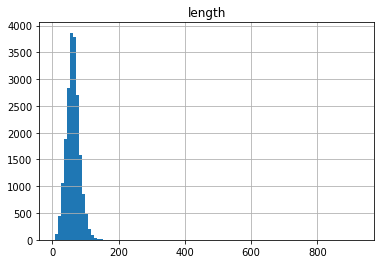

In [ ]:
train.hist(column='length',bins=100)


### Tokenization

Keras (a deep learning API in Python) already provides a Tokenizer to split the text into tokens. 

We can train the tokenizer on the texts of the training data. Using the parameter oov_token (oov = out of vocabulary), we can reserve a special token for unknown words (oov_token=True). This special token allow us to represent words (from new data) that the model has never seen. 

In [ ]:
from keras.preprocessing.text import Tokenizer

# create the tokenizer with the maximum number of words to keep, 
# based on word frequency. 
# Only the most common num_words-1 words will be kept.
tokenizer = Tokenizer(oov_token = True)

# fit the tokenizer on the headlines
tokenizer.fit_on_texts(list(train['headline']))
tokenizer.word_index['<PAD>'] = 0



In [ ]:
NUM_WORDS=len(tokenizer.word_index)
print("Vocabulary size ={}".format(NUM_WORDS))


Vocabulary size =25989


In [ ]:

# Transforms each text in texts to a sequence of integers.
encoded_train = tokenizer.texts_to_sequences(train['headline'])
encoded_test = tokenizer.texts_to_sequences(test['headline'])
encoded_val = tokenizer.texts_to_sequences(val['headline'])

We can see that the (training) sequences have different lengths:

In [ ]:
for i in range(5):
    print(train.iloc[i]['headline'])
    print(encoded_train[i], " len:", len(encoded_train[i]))
    print()

the great vanishing
[4, 317, 12918]  len: 3

mccain gets hammered at local vfw
[1468, 166, 9004, 15, 165, 12919]  len: 6

pissed off from a lack of sleep? you might be 'slangry'
[2453, 65, 16, 7, 1274, 3, 478, 19, 371, 24, 12920]  len: 11

sitting inside cardboard box the safest 6-year-old will feel for remainder of life
[1179, 435, 3432, 615, 4, 7039, 215, 46, 62, 42, 536, 6, 4934, 3, 66]  len: 15

marcellus williams prosecutor drew scrutiny in ferguson police shooting
[12921, 763, 3120, 5798, 9005, 5, 910, 126, 308]  len: 9



We want to study the length distribution of the input headline from the training texts. 

In [ ]:
length_tokens=pd.Series([len(v) for v in encoded_train])
length_tokens.describe(percentiles=[0.25,0.5,0.75,0.90, 0.95])

count    19952.000000
mean        10.252356
std          3.470537
min          2.000000
25%          8.000000
50%         10.000000
75%         12.000000
90%         14.000000
95%         16.000000
max        152.000000
dtype: float64

Therefore, most sequences have less than 16 tokens. So, we can define MAX_LENGTH as 20 tokens. 

In [ ]:
MAX_LEN=20

In this way, all sequences will be represented as vectors of dimension 20. Shorter sequences than 20 tokens will be extended by adding special pad tokens.
Larger sequences than 20 will be truncated (on the rigth). 


Each token is represented as a vector. We can use random vectors (which will be fitted during the training) or word embeddings from a pre-trained word embedding model. 

Then, a text could be represented as a matrix as many rows as number of tokens in the text. The number of columns will be the dimension of the vectors. 

The input of the CNN model will be matrices (as many matrices as texts in the training dataset). We need that all matrices have the same dimension (number of tokens * dimension of the vector). 
Therefore, we need that all texts have the same number of tokens. For this reason, we use the function pad_sequences. 


We need that all texts have the same number of tokens. 

In [ ]:
from keras.utils import pad_sequences 

# transforms a list of num_samples sequences (lists of integers)
# into a 2D Numpy array of shape (num_samples, num_timesteps).
encoded_train = pad_sequences(encoded_train, maxlen = MAX_LEN, padding='post')
encoded_val = pad_sequences(encoded_val, maxlen = MAX_LEN, padding='post')
encoded_test = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')


In [ ]:
for i in range(5):
    print(train.iloc[i]['headline'])
    print(encoded_train[i], ", len:", len(encoded_train[i]))
    print()

the great vanishing
[    4   317 12918     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0] , len: 20

mccain gets hammered at local vfw
[ 1468   166  9004    15   165 12919     0     0     0     0     0     0
     0     0     0     0     0     0     0     0] , len: 20

pissed off from a lack of sleep? you might be 'slangry'
[ 2453    65    16     7  1274     3   478    19   371    24 12920     0
     0     0     0     0     0     0     0     0] , len: 20

sitting inside cardboard box the safest 6-year-old will feel for remainder of life
[1179  435 3432  615    4 7039  215   46   62   42  536    6 4934    3
   66    0    0    0    0    0] , len: 20

marcellus williams prosecutor drew scrutiny in ferguson police shooting
[12921   763  3120  5798  9005     5   910   126   308     0     0     0
     0     0     0     0     0     0     0     0] , len: 20



We get the labels. We do not need to encoding them because they are all 0s or 1s. 

In [ ]:
y_train = train['is_sarcastic']
y_test = test['is_sarcastic']
y_val = val['is_sarcastic']

### Build CNN Model
Model Parameters:

- **Activation Function**: I have used ReLU as the activation function. ReLU is a non-linear activation function, which helps complex relationships in the data to be captured by the model.

- **Optimizer**: We use adam optimizer, which is an adaptive learning rate optimizer.

- **Loss function**: We will train a network to output a probability over the 2 classes using Sigmoid Loss.

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D

EMBEDDING_SIZE=200
model = Sequential()

model.add(Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=MAX_LEN))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 200)           5197800   
                                                                 
 conv1d (Conv1D)             (None, 20, 128)           102528    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 64)            32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 32)             8

### Save the best model and early stopping
To prevent the model from overfitting early stopping has been enabled.

Early stopping is a method that allows us to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out/validation dataset.


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Save the model after every epoch.
# saveBestModel = ModelCheckpoint(root+'CNNbest.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# Stop training when a monitored quantity has stopped improving.
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

### Fit the model

In [ ]:
# Fit the model
batch_size = 16 #number of samples processed before the model is updated.
epochs = 10 #number of complete passes through the training dataset.
#model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, validation_data=(val_X, val_y), callbacks=[saveBestModel, earlyStopping])
history=model.fit(encoded_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(encoded_val, y_val), callbacks=[earlyStopping])

Epoch 1/10
1247/1247 [==============================] - 16s 9ms/step - loss: 0.3850 - acc: 0.8172 - val_loss: 0.3239 - val_acc: 0.8568
Epoch 2/10
1247/1247 [==============================] - 8s 7ms/step - loss: 0.1088 - acc: 0.9589 - val_loss: 0.3998 - val_acc: 0.8495
Epoch 3/10
1247/1247 [==============================] - 9s 7ms/step - loss: 0.0195 - acc: 0.9934 - val_loss: 0.5816 - val_acc: 0.8463
Epoch 4/10
1247/1247 [==============================] - 9s 7ms/step - loss: 0.0099 - acc: 0.9968 - val_loss: 0.7094 - val_acc: 0.8386


Stops in the Epoch 5 out of 25, this is thanks to the validation set, that prevents us to overfit the model.

### Evaluate model results with test data

In [ ]:
model.metrics_names

['loss', 'acc']

By using the evaluate method, we can assess the model on the test split. However, this method only return the loss (0.6217) and accuracy (0.85) scores. 

In [ ]:
loss, accuracy = model.evaluate(encoded_test, y_test, batch_size=batch_size)

357/357 [==============================] - 1s 3ms/step - loss: 0.6217 - acc: 0.8535


We can use the sklearn library to obtain other metrics such as precision, recall and f1. We use the predict model to obtain the predictions for the test dataset:

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report 

y_pred = np.round(model.predict(encoded_test))

print('accuracy:', accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))




179/179 [==============================] - 0s 2ms/step
accuracy: 0.8535344676372566
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      2989
           1       0.85      0.84      0.84      2712

    accuracy                           0.85      5701
   macro avg       0.85      0.85      0.85      5701
weighted avg       0.85      0.85      0.85      5701



In [ ]:
from sklearn.metrics import  confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
tn, fp, fn, tp = cf_matrix.ravel()
print('tn, fp, fn, tp:',tn,fp,fn,tp)

print()


[[2590  399]
 [ 436 2276]]
tn, fp, fn, tp: 2590 399 436 2276



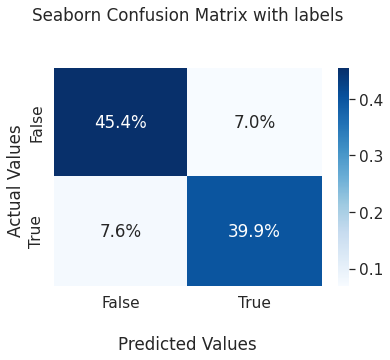

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.1%', cmap='Blues')
# ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()